<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap08/8_1_MNIST_1D_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 8.1: MNIST_1D_Performance**

This notebook runs a simple neural network on the MNIST1D dataset as in figure 8.2a. It uses code from https://github.com/greydanus/mnist1d to generate the data.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [1]:
# Run this if you're in a Colab to install MNIST 1D repository
%pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /tmp/pip-req-build-vxwki7_1
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /tmp/pip-req-build-vxwki7_1
  Resolved https://github.com/greydanus/mnist1d to commit 350929d12f4c9a4b7355e0c96604e41b9239bdb4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mnist1d: filename=mnist1d-0.0.2.post9-py3-none-any.whl size=14496 sha256=8208904aee8f6dad7934d30317ca33f8b9ffb3b59726aa36dc0bbae5fdadc6a8
  Stored in directory: /tmp/pip-ephem-wheel-cache-6pr7dbx9/wheels/41/95/55/45fcf7d38cfa97e35682da6c5017d4513729131326ce935371
Successfully built mnist1d


In [2]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d

Let's generate a training and test dataset using the MNIST1D code.  The dataset gets saved as a .pkl file so it doesn't have to be regenerated each time.

In [3]:
!mkdir ./sample_data

args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./sample_data/mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

mkdir: cannot create directory ‘./sample_data’: File exists
Did or could not load data from ./sample_data/mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [4]:
D_i = 40    # Input dimensions
D_k = 100   # Hidden dimensions
D_o = 10    # Output dimensions
# TO DO:
# Define a model with two hidden layers of size 100
# And ReLU activations between them
# Replace this line (see Figure 7.8 of book for help):

model = torch.nn.Sequential(
    torch.nn.Linear(D_i, D_k),   # First hidden layer
    torch.nn.ReLU(),             # ReLU activation
    torch.nn.Linear(D_k, D_k),   # Second hidden layer
    torch.nn.ReLU(),             # ReLU activation
    torch.nn.Linear(D_k, D_o)    # Output layer
)

import torch.nn.init as init

def weights_init(layer):
    if isinstance(layer, torch.nn.Linear):
        init.kaiming_uniform_(layer.weight.data, mode='fan_in', nonlinearity='relu')
        init.zeros_(layer.bias.data)

        print("Initializing layer")

# Call the function you just defined
model.apply(weights_init)

Initializing layer
Initializing layer
Initializing layer


Sequential(
  (0): Linear(in_features=40, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=10, bias=True)
)

In [5]:
# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 10 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('long'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('long'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 50
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_test = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_test[epoch]= loss_function(pred_test, y_test).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

Initializing layer
Initializing layer
Initializing layer
Epoch     0, train loss 1.625846, train error 63.40,  test loss 1.709190, test error 68.60
Epoch     1, train loss 1.329390, train error 49.62,  test loss 1.498328, test error 61.70
Epoch     2, train loss 1.155711, train error 41.62,  test loss 1.353210, test error 52.90
Epoch     3, train loss 0.994064, train error 35.62,  test loss 1.255204, test error 48.00
Epoch     4, train loss 0.875715, train error 31.18,  test loss 1.174382, test error 46.00
Epoch     5, train loss 0.817992, train error 30.00,  test loss 1.192478, test error 46.30
Epoch     6, train loss 0.705200, train error 26.18,  test loss 1.161025, test error 46.30
Epoch     7, train loss 0.630032, train error 22.15,  test loss 1.172501, test error 44.20
Epoch     8, train loss 0.552145, train error 18.55,  test loss 1.116410, test error 41.40
Epoch     9, train loss 0.519178, train error 18.35,  test loss 1.110260, test error 39.30
Epoch    10, train loss 0.402316,

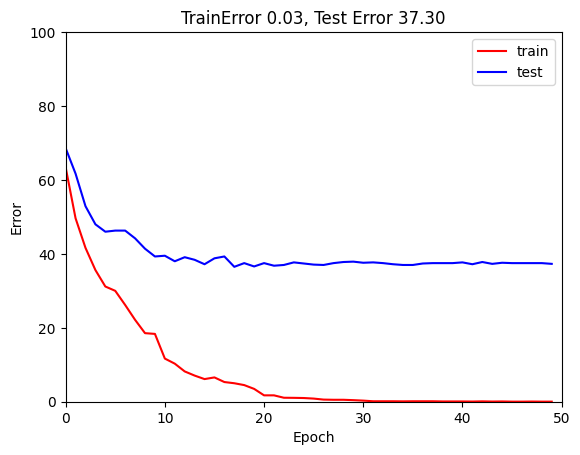

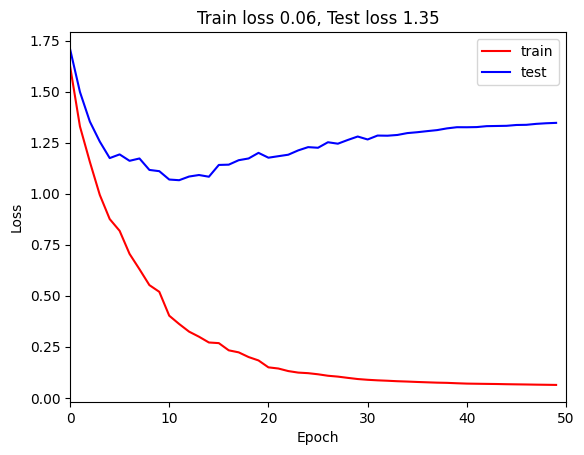

In [6]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
ax.legend()
plt.show()

# Plot the results
fig, ax = plt.subplots()
ax.plot(losses_train,'r-',label='train')
ax.plot(losses_test,'b-',label='test')
ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title('Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
ax.legend()
plt.show()

**TO DO**

Play with the model -- try changing the number of layers, hidden units, learning rate, batch size, momentum or anything else you like.  See if you can improve the test results.

Is it a good idea to optimize the hyperparameters in this way?  Will the final result be a good estimate of the true test performance?

In [7]:
D_i = 40    # Input dimensions
D_k = 100   # Hidden dimensions
D_o = 10    # Output dimensions

# Define a model with four hidden layers of size 100 and ReLU activations between them
model = torch.nn.Sequential(
    torch.nn.Linear(D_i, D_k),   # First hidden layer
    torch.nn.ReLU(),             # ReLU activation
    torch.nn.Linear(D_k, D_k),   # Second hidden layer
    torch.nn.ReLU(),             # ReLU activation
    torch.nn.Linear(D_k, D_k),   # Third hidden layer
    torch.nn.ReLU(),             # ReLU activation
    torch.nn.Linear(D_k, D_k),   # Fourth hidden layer
    torch.nn.ReLU(),             # ReLU activation
    torch.nn.Linear(D_k, D_o)    # Output layer
)

import torch.nn.init as init

def weights_init(layer):
    if isinstance(layer, torch.nn.Linear):
        init.kaiming_uniform_(layer.weight.data, mode='fan_in', nonlinearity='relu')
        init.zeros_(layer.bias.data)

# Call the function you just defined
model.apply(weights_init)

Sequential(
  (0): Linear(in_features=40, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): Linear(in_features=100, out_features=10, bias=True)
)

In [8]:

# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum=0.9)  #lr=0.05
# object that decreases learning rate by half every 10 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('long'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('long'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=50, shuffle=True, worker_init_fn=np.random.seed(1))   #batch_size=100

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 20
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_test = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_test[epoch]= loss_function(pred_test, y_test).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

Epoch     0, train loss 1.599997, train error 66.07,  test loss 1.625184, test error 68.80
Epoch     1, train loss 1.448668, train error 59.85,  test loss 1.501790, test error 62.10
Epoch     2, train loss 1.387145, train error 56.78,  test loss 1.471817, test error 59.70
Epoch     3, train loss 1.293795, train error 53.10,  test loss 1.368984, test error 58.80
Epoch     4, train loss 1.299521, train error 48.95,  test loss 1.398897, test error 54.70
Epoch     5, train loss 1.129388, train error 44.88,  test loss 1.330572, test error 49.00
Epoch     6, train loss 1.158837, train error 46.00,  test loss 1.274481, test error 52.40
Epoch     7, train loss 1.035981, train error 40.53,  test loss 1.226329, test error 48.10
Epoch     8, train loss 1.112256, train error 43.47,  test loss 1.323663, test error 50.90
Epoch     9, train loss 1.065800, train error 39.22,  test loss 1.373308, test error 49.90
Epoch    10, train loss 0.768669, train error 28.32,  test loss 1.132374, test error 42.10

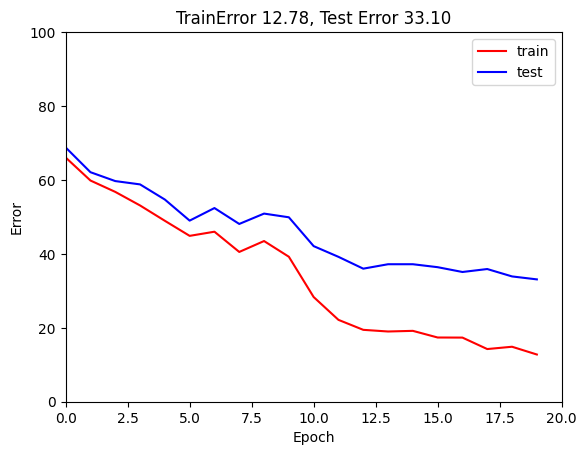

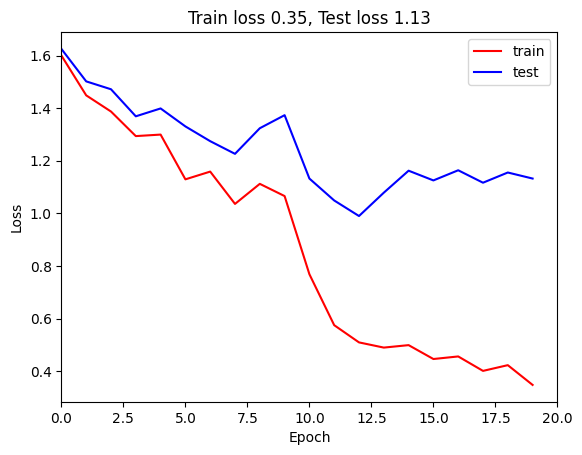

In [9]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
ax.legend()
plt.show()

# Plot the results
fig, ax = plt.subplots()
ax.plot(losses_train,'r-',label='train')
ax.plot(losses_test,'b-',label='test')
ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title('Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
ax.legend()
plt.show()